# 🧬 N2V Experiment Pipeline - Multi-Seed Training with PSNR Tracking

**Experimental Setup:**
- Single noisy 128×128×1 image
- Patch masking: 7×7 blind spots, 10% mask ratio, zero replacement
- MSE loss computed ONLY on masked pixels
- U-Net: 4 base channels, depth 3, ReLU, Kaiming init
- Training: up to 150 epochs, lr=1e-3
- Per-epoch checkpoints saved
- Best epoch selected by PSNR (if ground truth available)
- Multiple independent seed runs with logging

---

## Experiment Configuration

| Parameter | Value | Description |
|-----------|-------|-------------|
| Image Size | 128×128×1 | Single channel |
| Mask Patch | 7×7 | Blind spot size |
| Mask Ratio | 10% | Pixels masked per patch |
| Replacement | Zero | Masked pixel value |
| U-Net Channels | 4 | Base width (very small) |
| U-Net Depth | 3 | Encoder/decoder levels |
| Activation | ReLU | Default in UNet |
| Weight Init | Kaiming | He initialization |
| Learning Rate | 1e-3 | Adam optimizer |
| Max Epochs | 150 | Training limit |
| Num Seeds | 5 | Independent runs |

---

## 📁 Section 1: Mount Google Drive

In [1]:
# ============================================================
# MOUNT DRIVE & BASIC IMPORTS
# ============================================================
# These imports are needed early for data loading

from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
import matplotlib.pyplot as plt
import tifffile

# Define paths - SEPARATE DIRECTORIES for N2V and PN2V results
DRIVE_PROJECT_PATH = '/content/drive/MyDrive/PPN2V'

# ========== DATA PATH - YOUR DATASET_01 FOLDER ==========
DRIVE_DATA_PATH = '/content/drive/MyDrive/PPN2V/DATASET_01'

# Stage 1: N2V results
N2V_RESULTS_PATH = '/content/drive/MyDrive/PPN2V/results/DATASET_01/n2v_optimized'

# Stage 2: PN2V results
PN2V_RESULTS_PATH = '/content/drive/MyDrive/PPN2V/results/DATASET_01/pn2v_bootstrap'

# Final comparison
COMPARISON_PATH = '/content/drive/MyDrive/PPN2V/results/DATASET_01/comparison'

# Create all directories
for path in [N2V_RESULTS_PATH, PN2V_RESULTS_PATH, COMPARISON_PATH]:
    os.makedirs(path, exist_ok=True)

print(f"✓ Drive mounted")
print(f"\n📁 Data Path:     {DRIVE_DATA_PATH}")
print(f"📁 Output Directories:")
print(f"  N2V Results:    {N2V_RESULTS_PATH}")
print(f"  PN2V Results:   {PN2V_RESULTS_PATH}")
print(f"  Comparison:     {COMPARISON_PATH}")

Mounted at /content/drive
✓ Drive mounted

📁 Data Path:     /content/drive/MyDrive/PPN2V/DATASET_01
📁 Output Directories:
  N2V Results:    /content/drive/MyDrive/PPN2V/results/DATASET_01/n2v_optimized
  PN2V Results:   /content/drive/MyDrive/PPN2V/results/DATASET_01/pn2v_bootstrap
  Comparison:     /content/drive/MyDrive/PPN2V/results/DATASET_01/comparison


## 📥 Section 2: Clone Repository & Install

In [2]:
import subprocess
import sys

# Clone or update repository
REPO_PATH = '/content/PPN2V'
GITHUB_REPO = 'https://github.com/ZurvanAkarna/PPN2V.git'

if os.path.exists(REPO_PATH):
    print("Repository exists, pulling latest changes...")
    os.chdir(REPO_PATH)
    subprocess.run(['git', 'pull'], check=True)
else:
    print("Cloning repository...")
    subprocess.run(['git', 'clone', GITHUB_REPO, REPO_PATH], check=True)
    os.chdir(REPO_PATH)

# Install the package
print("\nInstalling PPN2V package...")
subprocess.run([sys.executable, '-m', 'pip', 'install', '-e', '.', '-q'], check=True)

# Install additional dependencies
subprocess.run([sys.executable, '-m', 'pip', 'install', 'tifffile', 'scikit-image', '-q'], check=True)

print("\n✓ Installation complete!")

Cloning repository...

Installing PPN2V package...

✓ Installation complete!


## ⚙️ Section 3: Configuration

In [ ]:
# ============================================================
# 📋 EXPERIMENT CONFIGURATION
# ============================================================
# Requirements:
# - 128×128×1 image, mask_patch=7, mask_ratio=0.1, zero replacement
# - U-Net: C=4 base channels, depth=3, ReLU, Kaiming init
# - lr=1e-3, max 150 epochs
# - Per-epoch checkpoints, PSNR-based best selection
# - Multiple seed runs with logging

CONFIG = {
    # Data settings
    'data_name': 'DATASET_01',
    'data_file': 'noisy_image_jitter_skips_0__0_3_flags_0__0_4_Gaussian_0.6.tif',
    'ground_truth_file': 'jittered_image.tif',  # Set to filename if GT available for PSNR

    # ========== EXPERIMENT PARAMETERS ==========
    # Network architecture (YOUR REQUIREMENTS)
    'net_depth': 3,                     # U-Net depth
    'net_start_filts': 4,               # Base channels C=4 (YOUR REQUIREMENT)

    # Masking parameters (YOUR REQUIREMENTS)
    'mask_patch_size': 7,               # 7×7 blind spot patches
    'mask_ratio': 0.10,                 # 10% pixels masked (YOUR REQUIREMENT)

    # Training parameters (YOUR REQUIREMENTS)
    'n2v_max_epochs': 150,              # Max epochs (YOUR REQUIREMENT)
    'n2v_steps_per_epoch': 10,          # Steps per epoch
    'n2v_batch_size': 1,                # Batch size
    'n2v_patch_size': 64,               # Training patch size
    'learning_rate': 0.001,             # Adam lr = 1e-3 (YOUR REQUIREMENT)

    # Multi-seed experiment (YOUR REQUIREMENTS)
    'num_seeds': 5,                     # Number of independent runs
    'base_seed': 42,                    # Starting seed for reproducibility

    # Checkpoint settings
    'save_every_epoch': True,           # Save checkpoint each epoch
    'use_psnr_selection': True,         # Use PSNR (not loss) for best model

    # ========== STAGE 2: PN2V Bootstrap (optional) ==========
    'run_pn2v': False,                  # Set True to run PN2V after N2V
    'n_gaussian': 3,
    'n_coeff': 2,
    'gmm_epochs': 2000,
    'gmm_batch_size': 250000,           # FIXED: 250k (original paper value, was 100k)
    'pn2v_num_samples': 800,            # FIXED: 800 (original paper value, was 100)
                                        #   More samples → better MMSE → fewer artifacts
    'pn2v_depth': 3,
    'pn2v_start_filts': 64,             # FIXED: 64 (original paper value, was 4)
                                        #   Too few filters → hallucinated structures
    'pn2v_max_epochs': 200,             # FIXED: 200 (original paper value, was 150)
    'pn2v_steps_per_epoch': 5,          # Steps per epoch (original: 5)
    'pn2v_batch_size': 1,               # Batch size (original: 1)
    'pn2v_patch_size': 64,              # Patch size for training
    'pn2v_learning_rate': 0.001,
    'pn2v_patience': 50,                # Early stopping patience
}

# Print configuration
print("="*60)
print("EXPERIMENT CONFIGURATION")
print("="*60)
print(f"\n📄 Data file: {CONFIG['data_file']}")
print(f"📄 Ground truth: {CONFIG['ground_truth_file'] or 'Not provided (will use val loss)'}")
print("\n📌 Network Architecture:")
print(f"  U-Net depth: {CONFIG['net_depth']}")
print(f"  Base channels (C): {CONFIG['net_start_filts']}")
print(f"  Activation: ReLU")
print(f"  Weight init: Kaiming (He)")
print("\n📌 Masking:")
print(f"  Mask patch: {CONFIG['mask_patch_size']}×{CONFIG['mask_patch_size']}")
print(f"  Mask ratio: {CONFIG['mask_ratio']*100}%")
print(f"  Replacement: Zero")
print("\n📌 Training:")
print(f"  Max epochs: {CONFIG['n2v_max_epochs']}")
print(f"  Learning rate: {CONFIG['learning_rate']}")
print(f"  Batch size: {CONFIG['n2v_batch_size']}")
print("\n📌 Experiment:")
print(f"  Number of seeds: {CONFIG['num_seeds']}")
print(f"  Base seed: {CONFIG['base_seed']}")
print(f"  Per-epoch checkpoints: {CONFIG['save_every_epoch']}")
print(f"  PSNR-based selection: {CONFIG['use_psnr_selection']}")
print("\n📌 PN2V Bootstrap:")
print(f"  Output samples: {CONFIG['pn2v_num_samples']}")
print(f"  Start filters: {CONFIG['pn2v_start_filts']}")
print(f"  GMM batch size: {CONFIG['gmm_batch_size']}")
print("="*60)

EXPERIMENT CONFIGURATION

📄 Data file: noisy_image_jitter_skips_0__0_3_flags_0__0_4_Gaussian_0.6.tif
📄 Ground truth: Not provided (will use val loss)

📌 Network Architecture:
  U-Net depth: 3
  Base channels (C): 4
  Activation: ReLU
  Weight init: Kaiming (He)

📌 Masking:
  Mask patch: 7×7
  Mask ratio: 10.0%
  Replacement: Zero

📌 Training:
  Max epochs: 150
  Learning rate: 0.001
  Batch size: 1

📌 Experiment:
  Number of seeds: 5
  Base seed: 42
  Per-epoch checkpoints: True
  PSNR-based selection: True


## 🖼️ Section 4: Load Data


✓ Loaded image: (128, 128)
  Min: 0.00
  Max: 255.00
  Mean: 113.66
  Std: 32.89


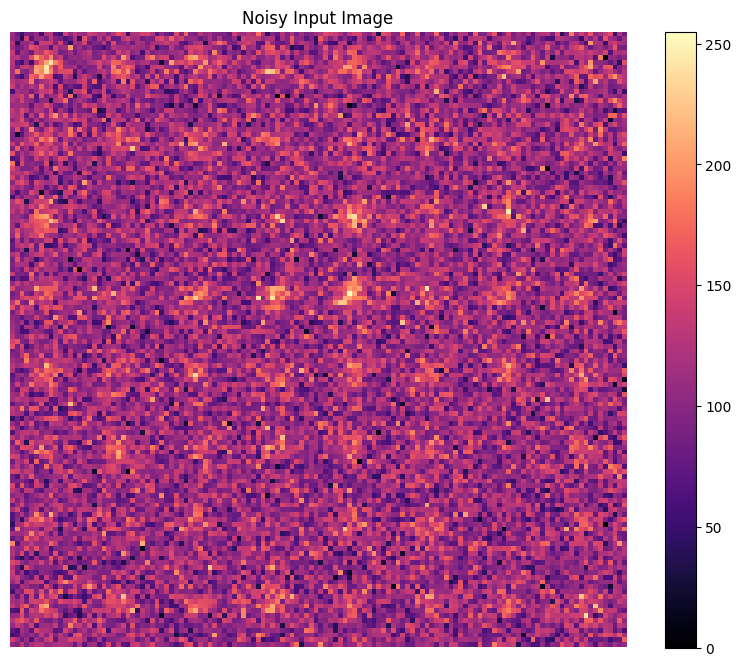

In [4]:
# Load noisy image (imports available from Section 5)
data_path = os.path.join(DRIVE_DATA_PATH, CONFIG['data_file'])

if not os.path.exists(data_path):
    print(f"⚠️  File not found: {data_path}")
    print(f"\nPlease upload your noisy image to:")
    print(f"  {DRIVE_DATA_PATH}/{CONFIG['data_file']}")
    print(f"\nOr modify CONFIG['data_file'] to match your filename.")
else:
    noisy_image = tifffile.imread(data_path).astype(np.float32)

    # Handle 3D stack - use first slice or choose
    if noisy_image.ndim == 3:
        print(f"Loaded 3D stack: {noisy_image.shape}")
        print(f"Using first slice for training...")
        noisy_image = noisy_image[0]  # Use first slice

    print(f"\n✓ Loaded image: {noisy_image.shape}")
    print(f"  Min: {noisy_image.min():.2f}")
    print(f"  Max: {noisy_image.max():.2f}")
    print(f"  Mean: {noisy_image.mean():.2f}")
    print(f"  Std: {noisy_image.std():.2f}")

    # Display
    plt.figure(figsize=(10, 8))
    plt.imshow(noisy_image, cmap='magma')
    plt.colorbar()
    plt.title('Noisy Input Image')
    plt.axis('off')
    plt.show()

## 🏗️ Section 5: Setup & Helper Functions

In [ ]:
# ============================================================
# ALL IMPORTS & SETUP
# ============================================================
# Consolidate all imports here to avoid dependency issues

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import init
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import pandas as pd
import sys
import os
import random
import copy
import time as time_module

# Add source to path (required for Colab)
sys.path.insert(0, '/content/PPN2V/src')

from ppn2v.unet.model import UNet
from ppn2v.pn2v import training, utils, prediction

# Check GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_mem / 1e9:.1f} GB")

# ============================================================
# HELPER FUNCTIONS
# ============================================================

def set_seed(seed):
    """Set all random seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    print(f"  Seed set to: {seed}")

def compute_psnr(gt, pred):
    """Compute PSNR between ground truth and prediction.
    
    Uses the ground truth data range (max - min) as the standard reference.
    This is the standard definition for microscopy images with arbitrary intensity ranges.
    """
    mse = np.mean((gt.astype(np.float64) - pred.astype(np.float64)) ** 2)
    if mse == 0:
        return float('inf')
    # Use ground truth range as reference (standard for microscopy)
    data_range = float(gt.max() - gt.min())
    if data_range == 0:
        return float('inf')
    psnr = 20 * np.log10(data_range / np.sqrt(mse))
    return psnr

def create_n2v_model(config, device):
    """Create and initialize N2V U-Net model."""
    net = UNet(
        num_classes=1,                              # N2V: single output
        in_channels=1,                              # Single channel input
        depth=config['net_depth'],                  # 3
        start_filts=config['net_start_filts'],      # 4 (YOUR REQUIREMENT)
        merge_mode='add'
    )

    # Apply KAIMING (He) initialization for ReLU
    def init_weights_kaiming(m):
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
            init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                init.constant_(m.bias, 0)

    net.apply(init_weights_kaiming)
    net = net.to(device)
    return net

def predict_and_compute_psnr(net, noisy_img, gt_img, device):
    """Run prediction and compute PSNR against ground truth."""
    net.eval()
    with torch.no_grad():
        # Ensure tile size is divisible by 2^depth
        depth = net.depth if hasattr(net, 'depth') else 3
        divisor = 2 ** depth
        raw_ps = min(128, noisy_img.shape[0], noisy_img.shape[1])
        ps = (raw_ps // divisor) * divisor
        if ps < divisor:
            ps = divisor

        # tiledPredict with noiseModel=None returns a single array (not a tuple)
        result = prediction.tiledPredict(
            im=noisy_img.astype(np.float32),
            net=net,
            ps=ps,
            overlap=32,
            noiseModel=None,
            device=device
        )
        # When noiseModel=None, tiledPredict returns just `means` (single array)
        denoised = result
    psnr = compute_psnr(gt_img, denoised)
    return denoised, psnr

# Print model info
test_net = create_n2v_model(CONFIG, device)
n_params = sum(p.numel() for p in test_net.parameters())
print(f"\nN2V Network Configuration:")
print(f"  Depth: {CONFIG['net_depth']}")
print(f"  Base channels (C): {CONFIG['net_start_filts']}")
print(f"  Activation: ReLU")
print(f"  Weight init: Kaiming (He)")
print(f"  Parameters: {n_params:,}")
del test_net
torch.cuda.empty_cache()

print("\n✓ All imports and setup complete!")

Using device: cuda
GPU: NVIDIA L4
Memory: 23.8 GB

N2V Network Configuration:
  Depth: 3
  Base channels (C): 4
  Activation: ReLU
  Weight init: Kaiming (He)
  Parameters: 6,678

✓ All imports and setup complete!


/content/PPN2V/src/ppn2v/unet/model.py:215: FutureWarning: `nn.init.xavier_normal` is now deprecated in favor of `nn.init.xavier_normal_`.
  init.xavier_normal(m.weight)
/content/PPN2V/src/ppn2v/unet/model.py:216: FutureWarning: `nn.init.constant` is now deprecated in favor of `nn.init.constant_`.
  init.constant(m.bias, 0)


## 🚀 Section 6: Multi-Seed Training with Per-Epoch Checkpoints

In [6]:
# ============================================================
# MULTI-SEED N2V TRAINING WITH PER-EPOCH CHECKPOINTS
# ============================================================
# Requirements met:
# - 128×128×1 image
# - mask_patch=7 (7×7), mask_ratio=0.1 (10%), zero replacement
# - MSE loss ONLY on masked pixels
# - U-Net: C=4 base channels, depth=3, ReLU, Kaiming init
# - lr=1e-3, up to 150 epochs
# - Per-epoch checkpoints, PSNR-based best model selection
# - N independent seed runs with logging
# ============================================================
# NOTE: All imports (torch.optim, time, etc.) available from Section 5

# Load ground truth if available (for PSNR-based selection)
ground_truth = None
if CONFIG['ground_truth_file']:
    gt_path = os.path.join(DRIVE_DATA_PATH, CONFIG['ground_truth_file'])
    if os.path.exists(gt_path):
        ground_truth = tifffile.imread(gt_path).astype(np.float32)
        if ground_truth.ndim == 3:
            ground_truth = ground_truth[0]
        print(f"✓ Ground truth loaded: {ground_truth.shape}")
    else:
        print(f"⚠️ Ground truth not found: {gt_path}")

# Prepare data
if noisy_image.ndim == 2:
    train_data = noisy_image[np.newaxis, :, :].copy()
    val_data = noisy_image[np.newaxis, :, :].copy()
else:
    train_data = noisy_image[:-5].copy()
    val_data = noisy_image[-5:].copy()

print(f"\n📊 Data Shapes:")
print(f"  Noisy image: {noisy_image.shape}")
print(f"  Train data: {train_data.shape}")
print(f"  Val data: {val_data.shape}")

# Calculate parameters
H, W = train_data.shape[1], train_data.shape[2]
patch_size = min(CONFIG['n2v_patch_size'], H, W)
num_masked_pixels = int(patch_size * patch_size * CONFIG['mask_ratio'])

print(f"\n📌 Training Parameters:")
print(f"  Patch size: {patch_size}×{patch_size}")
print(f"  Masked pixels per patch: {num_masked_pixels} ({CONFIG['mask_ratio']*100}%)")
print(f"  Mask patch size: {CONFIG['mask_patch_size']}×{CONFIG['mask_patch_size']}")
print(f"  Max epochs: {CONFIG['n2v_max_epochs']}")
print(f"  Number of seeds: {CONFIG['num_seeds']}")

# ============================================================
# CUSTOM TRAINING LOOP WITH PER-EPOCH CHECKPOINTS & PSNR
# ============================================================

def train_single_seed(seed, config, train_data, val_data, noisy_img, gt_img, device, results_path):
    """Train N2V for a single seed with per-epoch checkpoints and PSNR tracking."""

    set_seed(seed)
    seed_dir = os.path.join(results_path, f'seed_{seed}')
    os.makedirs(seed_dir, exist_ok=True)

    # Create fresh model
    net = create_n2v_model(config, device)

    # Compute normalization from data
    combined = np.concatenate((train_data, val_data))
    net.mean = np.mean(combined)
    net.std = np.std(combined)

    optimizer = optim.Adam(net.parameters(), lr=config['learning_rate'])

    # Training tracking
    train_hist = []
    val_hist = []
    psnr_hist = []
    best_psnr = -float('inf')
    best_loss = float('inf')
    best_epoch = 0

    patch_size = min(config['n2v_patch_size'], train_data.shape[1], train_data.shape[2])
    num_pix = int(patch_size * patch_size * config['mask_ratio'])

    print(f"\n{'='*60}")
    print(f"SEED {seed} - Starting Training")
    print(f"{'='*60}")

    start_time = time_module.time()

    for epoch in range(config['n2v_max_epochs']):
        # Training
        net.train()
        epoch_losses = []
        data_counter = 0

        for step in range(config['n2v_steps_per_epoch']):
            optimizer.zero_grad()

            # Virtual batch
            for _ in range(20):  # virtualBatchSize=20
                outputs, labels, masks, data_counter = training.trainingPred(
                    train_data, net, data_counter, patch_size,
                    config['n2v_batch_size'], num_pix, device,
                    augment=True, supervised=False,
                    maskPatchSize=config['mask_patch_size'],
                    useZeroReplacement=True
                )
                loss = training.lossFunctionN2V(outputs, labels, masks) / (net.std ** 2)
                loss.backward()
                epoch_losses.append(loss.item())

            optimizer.step()

        avg_train_loss = np.mean(epoch_losses)
        train_hist.append(avg_train_loss)

        # Validation
        net.eval()
        val_losses = []
        val_counter = 0
        with torch.no_grad():
            for _ in range(20):  # valSize=20
                outputs, labels, masks, val_counter = training.trainingPred(
                    val_data, net, val_counter, patch_size,
                    config['n2v_batch_size'], num_pix, device,
                    augment=True, supervised=False,
                    maskPatchSize=config['mask_patch_size'],
                    useZeroReplacement=True
                )
                loss = training.lossFunctionN2V(outputs, labels, masks) / (net.std ** 2)
                val_losses.append(loss.item())

        avg_val_loss = np.mean(val_losses)
        val_hist.append(avg_val_loss)

        # Compute PSNR if ground truth available
        current_psnr = None
        if gt_img is not None:
            _, current_psnr = predict_and_compute_psnr(net, noisy_img, gt_img, device)
            psnr_hist.append(current_psnr)

        # Save checkpoint EVERY epoch
        if config['save_every_epoch']:
            checkpoint_path = os.path.join(seed_dir, f'epoch_{epoch+1:03d}.net')
            torch.save(net, checkpoint_path)

        # Determine best model
        is_best = False
        if config['use_psnr_selection'] and current_psnr is not None:
            # Use PSNR for selection (higher is better)
            if current_psnr > best_psnr:
                best_psnr = current_psnr
                best_epoch = epoch + 1
                is_best = True
        else:
            # Use validation loss (lower is better)
            if avg_val_loss < best_loss:
                best_loss = avg_val_loss
                best_epoch = epoch + 1
                is_best = True

        if is_best:
            torch.save(net, os.path.join(seed_dir, 'best.net'))

        # Log progress every 10 epochs
        if (epoch + 1) % 10 == 0 or epoch == 0:
            psnr_str = f", PSNR: {current_psnr:.2f} dB" if current_psnr else ""
            best_str = f" ✓ BEST" if is_best else ""
            print(f"  Epoch {epoch+1:3d}/{config['n2v_max_epochs']}: "
                  f"Train={avg_train_loss:.6f}, Val={avg_val_loss:.6f}{psnr_str}{best_str}")

    # Save final model
    torch.save(net, os.path.join(seed_dir, 'last.net'))

    # Save histories
    np.save(os.path.join(seed_dir, 'train_hist.npy'), train_hist)
    np.save(os.path.join(seed_dir, 'val_hist.npy'), val_hist)
    if psnr_hist:
        np.save(os.path.join(seed_dir, 'psnr_hist.npy'), psnr_hist)

    elapsed = (time_module.time() - start_time) / 60

    # Results
    result = {
        'seed': seed,
        'best_epoch': best_epoch,
        'best_psnr': best_psnr if psnr_hist else None,
        'best_val_loss': min(val_hist),
        'final_train_loss': train_hist[-1],
        'final_val_loss': val_hist[-1],
        'train_hist': train_hist,
        'val_hist': val_hist,
        'psnr_hist': psnr_hist if psnr_hist else None,
        'elapsed_min': elapsed
    }

    print(f"\n  ✓ Seed {seed} complete in {elapsed:.1f} min")
    print(f"    Best epoch: {best_epoch}")
    if best_psnr > -float('inf'):
        print(f"    Best PSNR: {best_psnr:.2f} dB")
    print(f"    Best val loss: {min(val_hist):.6f}")

    # Cleanup
    del net
    torch.cuda.empty_cache()

    return result

# ============================================================
# RUN ALL SEEDS
# ============================================================

all_results = []

print("\n" + "="*60)
print(f"STARTING {CONFIG['num_seeds']}-SEED EXPERIMENT")
print("="*60)

for i in range(CONFIG['num_seeds']):
    seed = CONFIG['base_seed'] + i
    result = train_single_seed(
        seed=seed,
        config=CONFIG,
        train_data=train_data,
        val_data=val_data,
        noisy_img=noisy_image,
        gt_img=ground_truth,
        device=device,
        results_path=N2V_RESULTS_PATH
    )
    all_results.append(result)

# ============================================================
# SUMMARY TABLE
# ============================================================

print("\n" + "="*60)
print("EXPERIMENT SUMMARY")
print("="*60)
print(f"\n{'Seed':<8} {'Best Epoch':<12} {'Best PSNR':<12} {'Best Val Loss':<15}")
print("-"*50)

psnr_values = []
for r in all_results:
    psnr_str = f"{r['best_psnr']:.2f} dB" if r['best_psnr'] else "N/A"
    print(f"{r['seed']:<8} {r['best_epoch']:<12} {psnr_str:<12} {r['best_val_loss']:.6f}")
    if r['best_psnr']:
        psnr_values.append(r['best_psnr'])

if psnr_values:
    print("-"*50)
    print(f"{'Mean':<8} {'':<12} {np.mean(psnr_values):.2f} dB")
    print(f"{'Std':<8} {'':<12} {np.std(psnr_values):.2f} dB")

# Save summary
summary = {
    'config': CONFIG,
    'results': all_results,
    'mean_psnr': np.mean(psnr_values) if psnr_values else None,
    'std_psnr': np.std(psnr_values) if psnr_values else None
}
np.save(os.path.join(N2V_RESULTS_PATH, 'experiment_summary.npy'), summary, allow_pickle=True)

print("\n✓ Experiment complete!")
print(f"  Results saved to: {N2V_RESULTS_PATH}")


📊 Data Shapes:
  Noisy image: (128, 128)
  Train data: (1, 128, 128)
  Val data: (1, 128, 128)

📌 Training Parameters:
  Patch size: 64×64
  Masked pixels per patch: 409 (10.0%)
  Mask patch size: 7×7
  Max epochs: 150
  Number of seeds: 5

STARTING 5-SEED EXPERIMENT
  Seed set to: 42

SEED 42 - Starting Training
  Epoch   1/150: Train=5.170944, Val=1.821752 ✓ BEST
  Epoch  10/150: Train=1.084040, Val=1.109543
  Epoch  20/150: Train=1.041632, Val=1.048026
  Epoch  30/150: Train=1.026173, Val=1.035105
  Epoch  40/150: Train=1.021715, Val=1.030185
  Epoch  50/150: Train=1.017188, Val=1.015726
  Epoch  60/150: Train=1.006848, Val=1.006236
  Epoch  70/150: Train=1.005649, Val=1.002785
  Epoch  80/150: Train=0.996015, Val=1.010823
  Epoch  90/150: Train=0.990891, Val=0.982580
  Epoch 100/150: Train=0.979958, Val=0.978552
  Epoch 110/150: Train=0.970357, Val=0.958799 ✓ BEST
  Epoch 120/150: Train=0.952664, Val=0.974972
  Epoch 130/150: Train=0.956340, Val=0.965695
  Epoch 140/150: Train=0.9

## 🔮 Section 7: Prediction

In [ ]:
from ppn2v.pn2v import prediction

# ============================================================
# LOAD BEST MODEL FROM MULTI-SEED EXPERIMENT
# ============================================================
# We select the seed with highest PSNR (or lowest val loss if no GT)

if all_results:
    # Find best seed
    if all_results[0]['best_psnr'] is not None:
        # Use PSNR criterion
        best_result = max(all_results, key=lambda x: x['best_psnr'])
        print(f"Selected best seed by PSNR: seed {best_result['seed']} ({best_result['best_psnr']:.2f} dB)")
    else:
        # Use validation loss criterion
        best_result = min(all_results, key=lambda x: x['best_val_loss'])
        print(f"Selected best seed by val loss: seed {best_result['seed']} ({best_result['best_val_loss']:.6f})")

    best_seed = best_result['seed']
else:
    # Fallback: use base seed
    best_seed = CONFIG['base_seed']
    print(f"Using default seed: {best_seed}")

# Load best model from selected seed
seed_dir = os.path.join(N2V_RESULTS_PATH, f'seed_{best_seed}')
best_model_path = os.path.join(seed_dir, 'best.net')

n2v_net_loaded = torch.load(best_model_path, map_location=device, weights_only=False)
n2v_net_loaded = n2v_net_loaded.to(device)
n2v_net_loaded.eval()

print(f"\n✓ Loaded best model: {best_model_path}")
print(f"  From seed {best_seed}, epoch {best_result['best_epoch']}")
print(f"  Mean: {n2v_net_loaded.mean:.2f}")
print(f"  Std: {n2v_net_loaded.std:.2f}")

# Prepare image for prediction (ensure 2D)
noisy_for_pred = np.squeeze(noisy_image).astype(np.float32)

# Ensure tile size is divisible by 2^depth
depth = CONFIG['net_depth']
divisor = 2 ** depth
raw_ps = min(256, noisy_for_pred.shape[0], noisy_for_pred.shape[1])
ps = (raw_ps // divisor) * divisor
if ps < divisor:
    ps = divisor

# Use the original prediction function (tiledPredict for large images)
# IMPORTANT: For N2V (noiseModel=None), tiledPredict returns ONLY the mean (single array)
n2v_denoised = prediction.tiledPredict(
    im=noisy_for_pred,
    net=n2v_net_loaded,
    ps=ps,               # Tile size (divisible by 2^depth)
    overlap=48,           # Overlap between tiles
    noiseModel=None,      # None for standard N2V - returns single array!
    device=device
)

print(f"\n✓ N2V Prediction complete!")
print(f"  Denoised image shape: {n2v_denoised.shape}")
print(f"  Min: {n2v_denoised.min():.2f}")
print(f"  Max: {n2v_denoised.max():.2f}")

# Final PSNR if ground truth available
if ground_truth is not None:
    final_psnr = compute_psnr(ground_truth, n2v_denoised)
    print(f"  Final PSNR: {final_psnr:.2f} dB")

Selected best seed by val loss: seed 42 (0.922737)

✓ Loaded best model: /content/drive/MyDrive/PPN2V/results/DATASET_01/n2v_optimized/seed_42/best.net
  From seed 42, epoch 145
  Mean: 113.66
  Std: 32.89

✓ N2V Prediction complete!
  Denoised image shape: (128, 128)
  Min: 94.39
  Max: 277.76


## 📊 Section 8: N2V Results Visualization

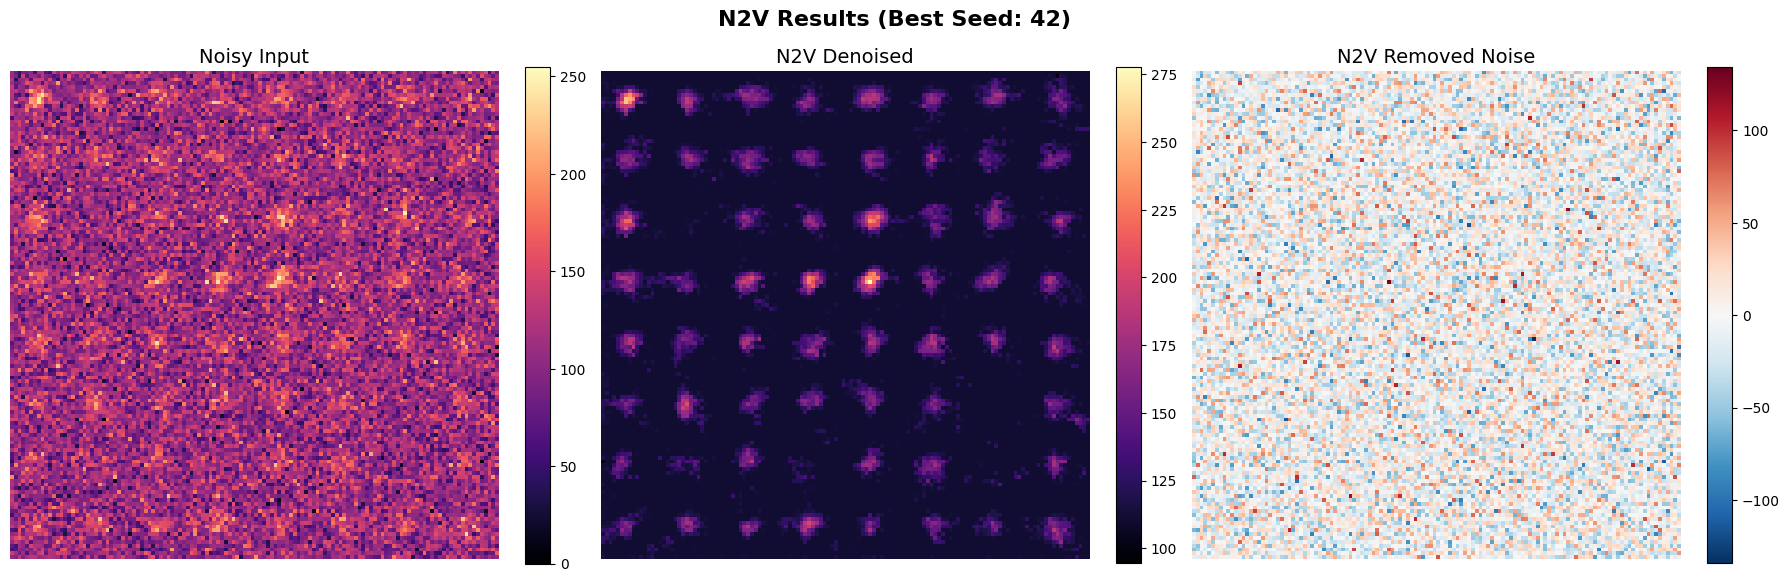

✓ Per-epoch averages saved to: /content/drive/MyDrive/PPN2V/results/DATASET_01/n2v_optimized/epoch_averages.csv
✓ Average loss plot saved to: /content/drive/MyDrive/PPN2V/results/DATASET_01/n2v_optimized/avg_loss_vs_epochs.png


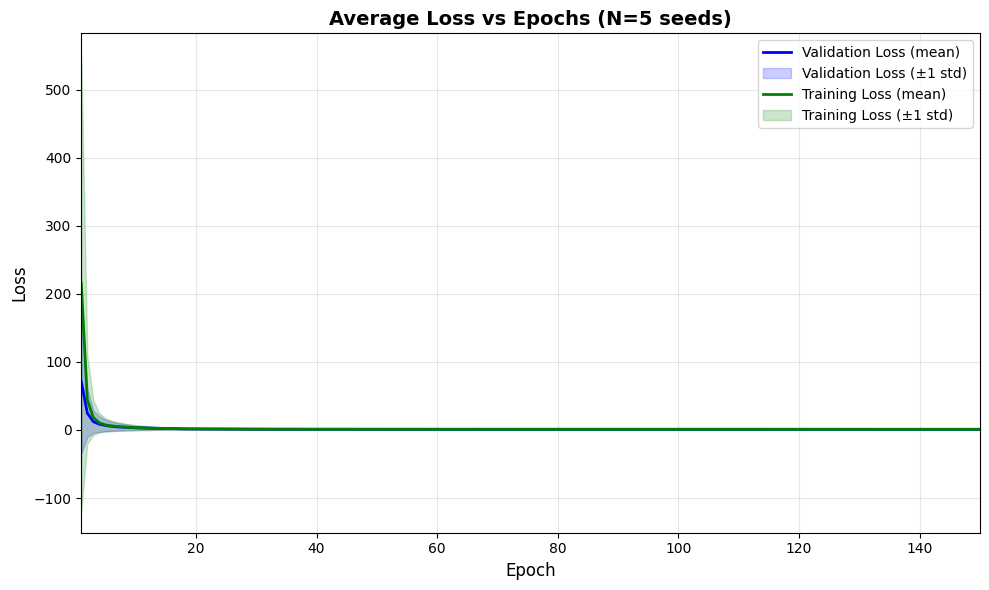


⚠️ No ground truth provided - PSNR plots skipped
To enable PSNR tracking, set CONFIG['ground_truth_file'] to your GT filename


In [ ]:
# ============================================================
# MULTI-SEED EXPERIMENT VISUALIZATION
# ============================================================
# NOTE: All imports (pd, plt, np, etc.) available from Section 5

# 1. N2V Side-by-side comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Noisy input
im0 = axes[0].imshow(noisy_image, cmap='magma')
axes[0].set_title('Noisy Input', fontsize=14)
axes[0].axis('off')
plt.colorbar(im0, ax=axes[0], fraction=0.046)

# N2V Denoised output
im1 = axes[1].imshow(n2v_denoised, cmap='magma')
title_psnr = f" ({compute_psnr(ground_truth, n2v_denoised):.2f} dB)" if ground_truth is not None else ""
axes[1].set_title(f'N2V Denoised{title_psnr}', fontsize=14)
axes[1].axis('off')
plt.colorbar(im1, ax=axes[1], fraction=0.046)

# Difference (noise removed)
n2v_difference = noisy_image - n2v_denoised
vmax = np.abs(n2v_difference).max()
im2 = axes[2].imshow(n2v_difference, cmap='RdBu_r', vmin=-vmax, vmax=vmax)
axes[2].set_title('N2V Removed Noise', fontsize=14)
axes[2].axis('off')
plt.colorbar(im2, ax=axes[2], fraction=0.046)

plt.suptitle(f'N2V Results (Best Seed: {best_seed})', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(N2V_RESULTS_PATH, 'n2v_comparison.png'), dpi=150, bbox_inches='tight')
plt.show()

# ============================================================
# 2. COMPUTE AVERAGES ACROSS SEEDS
# ============================================================
n_epochs = len(all_results[0]['val_hist'])
epochs = np.arange(1, n_epochs + 1)

# Stack all histories into arrays [n_seeds, n_epochs]
val_loss_all = np.array([r['val_hist'] for r in all_results])
train_loss_all = np.array([r['train_hist'] for r in all_results])

# Compute mean and std
val_loss_mean = np.mean(val_loss_all, axis=0)
val_loss_std = np.std(val_loss_all, axis=0)
train_loss_mean = np.mean(train_loss_all, axis=0)
train_loss_std = np.std(train_loss_all, axis=0)

# PSNR averages (if available)
has_psnr = all_results[0]['psnr_hist'] is not None
if has_psnr:
    psnr_all = np.array([r['psnr_hist'] for r in all_results])
    psnr_mean = np.mean(psnr_all, axis=0)
    psnr_std = np.std(psnr_all, axis=0)

    # Find best average PSNR and its epoch
    best_avg_psnr_idx = np.argmax(psnr_mean)
    best_avg_psnr_epoch = best_avg_psnr_idx + 1  # 1-indexed
    best_avg_psnr_value = psnr_mean[best_avg_psnr_idx]

    # Noisy baseline PSNR
    noisy_psnr = compute_psnr(ground_truth, noisy_image)

    print(f"📊 Best Average PSNR: {best_avg_psnr_value:.2f} dB @ epoch {best_avg_psnr_epoch}")
    print(f"📊 Noisy Baseline PSNR: {noisy_psnr:.2f} dB")

# ============================================================
# 3. SAVE AVERAGES TO CSV
# ============================================================
csv_data = {
    'epoch': epochs,
    'train_loss_mean': train_loss_mean,
    'train_loss_std': train_loss_std,
    'val_loss_mean': val_loss_mean,
    'val_loss_std': val_loss_std,
}
if has_psnr:
    csv_data['psnr_mean'] = psnr_mean
    csv_data['psnr_std'] = psnr_std

df_averages = pd.DataFrame(csv_data)
csv_path = os.path.join(N2V_RESULTS_PATH, 'epoch_averages.csv')
df_averages.to_csv(csv_path, index=False)
print(f"✓ Per-epoch averages saved to: {csv_path}")

# ============================================================
# 4. FIGURE 1: AVERAGED LOSS vs EPOCHS
# ============================================================
if has_psnr:
    fig, ax = plt.subplots(figsize=(8, 5))

    # Validation loss: blue line with shaded ±1 std
    ax.plot(epochs, val_loss_mean, color='tab:blue', lw=1.8, label='Validation Loss (mean)')
    ax.fill_between(epochs,
                    val_loss_mean - val_loss_std,
                    val_loss_mean + val_loss_std,
                    color='tab:blue', alpha=0.18)

    # Training loss: orange line with shaded ±1 std
    ax.plot(epochs, train_loss_mean, color='tab:orange', lw=1.8, label='Training Loss (mean)')
    ax.fill_between(epochs,
                    train_loss_mean - train_loss_std,
                    train_loss_mean + train_loss_std,
                    color='tab:orange', alpha=0.18)

    # Vertical dashed red line at best-PSNR epoch
    ax.axvline(best_avg_psnr_epoch, color='red', linestyle='--', lw=1.5, alpha=0.85,
               label=f'Best PSNR epoch = {best_avg_psnr_epoch}')

    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Loss', fontsize=12)
    ax.set_title(f'Averaged Loss vs Epochs (N={CONFIG["num_seeds"]} seeds)',
                 fontsize=13, fontweight='bold')
    ax.legend(loc='upper right', fontsize=9, framealpha=0.9)
    ax.set_xlim(1, n_epochs)
    ax.grid(True, alpha=0.25, linestyle='-')
    ax.tick_params(labelsize=10)

    plt.tight_layout()
    loss_plot_path = os.path.join(N2V_RESULTS_PATH, 'avg_loss_vs_epochs.png')
    plt.savefig(loss_plot_path, dpi=200, bbox_inches='tight')
    print(f"✓ Loss plot saved: {loss_plot_path}")
    plt.show()

    # ============================================================
    # 5. FIGURE 2: AVERAGED PSNR vs EPOCHS
    # ============================================================
    fig, ax = plt.subplots(figsize=(8, 5))

    # PSNR curve: blue line with shaded ±1 std
    ax.plot(epochs, psnr_mean, color='tab:blue', lw=1.8, label='PSNR (mean)')
    ax.fill_between(epochs,
                    psnr_mean - psnr_std,
                    psnr_mean + psnr_std,
                    color='tab:blue', alpha=0.18)

    # Red "X" marker at peak
    ax.plot(best_avg_psnr_epoch, best_avg_psnr_value, 'rX', markersize=14,
            markeredgewidth=2.0, zorder=5)

    # Annotation with arrow pointing to peak
    # Position the text box to the right-below of the peak
    offset_x = n_epochs * 0.12
    offset_y = (psnr_mean.max() - psnr_mean.min()) * 0.18
    ax.annotate(
        f'Best PSNR: {best_avg_psnr_value:.2f} dB\nepoch = {best_avg_psnr_epoch}',
        xy=(best_avg_psnr_epoch, best_avg_psnr_value),
        xytext=(best_avg_psnr_epoch + offset_x, best_avg_psnr_value - offset_y),
        fontsize=10, fontweight='bold', color='red',
        arrowprops=dict(arrowstyle='->', color='red', lw=1.5),
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='red', alpha=0.9)
    )

    # Horizontal dashed red line at noisy-image baseline PSNR
    ax.axhline(noisy_psnr, color='red', linestyle='--', lw=1.2, alpha=0.7,
               label=f'Noisy baseline = {noisy_psnr:.2f} dB')

    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('PSNR (dB)', fontsize=12)
    ax.set_title(f'Averaged PSNR vs Epochs (N={CONFIG["num_seeds"]} seeds)',
                 fontsize=13, fontweight='bold')
    ax.legend(loc='lower right', fontsize=9, framealpha=0.9)
    ax.set_xlim(1, n_epochs)
    ax.grid(True, alpha=0.25, linestyle='-')
    ax.tick_params(labelsize=10)

    plt.tight_layout()
    psnr_plot_path = os.path.join(N2V_RESULTS_PATH, 'avg_psnr_vs_epochs.png')
    plt.savefig(psnr_plot_path, dpi=200, bbox_inches='tight')
    print(f"✓ PSNR plot saved: {psnr_plot_path}")
    plt.show()

    # Summary
    print("\n" + "="*50)
    print("EXPERIMENT SUMMARY")
    print("="*50)
    print(f"Number of seeds: {CONFIG['num_seeds']}")
    print(f"Best avg PSNR: {best_avg_psnr_value:.2f} ± {psnr_std[best_avg_psnr_idx]:.2f} dB  @ epoch {best_avg_psnr_epoch}")
    print(f"Noisy baseline: {noisy_psnr:.2f} dB")
    psnr_vals = [r['best_psnr'] for r in all_results]
    print(f"Best individual PSNR: {max(psnr_vals):.2f} dB (seed {best_seed})")

else:
    # Fallback: loss-only plot when no ground truth
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(epochs, val_loss_mean, color='tab:blue', lw=1.8, label='Validation Loss (mean)')
    ax.fill_between(epochs, val_loss_mean - val_loss_std, val_loss_mean + val_loss_std,
                    color='tab:blue', alpha=0.18)
    ax.plot(epochs, train_loss_mean, color='tab:orange', lw=1.8, label='Training Loss (mean)')
    ax.fill_between(epochs, train_loss_mean - train_loss_std, train_loss_mean + train_loss_std,
                    color='tab:orange', alpha=0.18)
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Loss', fontsize=12)
    ax.set_title(f'Averaged Loss vs Epochs (N={CONFIG["num_seeds"]} seeds)', fontsize=13, fontweight='bold')
    ax.legend(loc='upper right', fontsize=9)
    ax.set_xlim(1, n_epochs)
    ax.grid(True, alpha=0.25)
    plt.tight_layout()
    plt.savefig(os.path.join(N2V_RESULTS_PATH, 'avg_loss_vs_epochs.png'), dpi=200, bbox_inches='tight')
    plt.show()
    print("\n⚠️ No ground truth provided — PSNR plot skipped")
    print("Set CONFIG['ground_truth_file'] to enable PSNR tracking")

## 💾 Section 9: Save N2V Results

In [ ]:
# Save N2V denoised image
n2v_output_filename = f"n2v_denoised_{CONFIG['data_name']}.tif"
n2v_output_path = os.path.join(N2V_RESULTS_PATH, n2v_output_filename)
tifffile.imwrite(n2v_output_path, n2v_denoised.astype(np.float32))
print(f"✓ N2V denoised image saved: {n2v_output_path}")

# Save N2V difference image (compute here to avoid dependency on Section 8)
n2v_difference = noisy_image - n2v_denoised
n2v_diff_filename = f"n2v_noise_removed_{CONFIG['data_name']}.tif"
n2v_diff_path = os.path.join(N2V_RESULTS_PATH, n2v_diff_filename)
tifffile.imwrite(n2v_diff_path, n2v_difference.astype(np.float32))
print(f"✓ N2V noise map saved: {n2v_diff_path}")

print("\n" + "="*60)
print("✅ STAGE 1 COMPLETE: N2V Results Saved")
print("="*60)
print(f"Results directory: {N2V_RESULTS_PATH}")
print("="*60)

✓ N2V denoised image saved: /content/drive/MyDrive/PPN2V/results/DATASET_01/n2v_optimized/n2v_denoised_DATASET_01.tif
✓ N2V noise map saved: /content/drive/MyDrive/PPN2V/results/DATASET_01/n2v_optimized/n2v_noise_removed_DATASET_01.tif

✅ STAGE 1 COMPLETE: N2V Results Saved
Results directory: /content/drive/MyDrive/PPN2V/results/DATASET_01/n2v_optimized


---
# 🔬 STAGE 2: PN2V Bootstrap

Now we use the N2V prediction as the "signal estimate" to build a noise model, then train PN2V for probabilistic denoising with uncertainty quantification.

---

## 🧪 Section 10: Create GMM Noise Model (Bootstrap)

In [10]:
# ============================================================
# 🧹 CRITICAL: Clear GPU memory before Stage 2
# ============================================================
import gc

# Delete N2V model to free GPU memory
# Note: Only n2v_net_loaded exists (from Section 7), not n2v_net
try:
    del n2v_net_loaded
    print("✓ Deleted n2v_net_loaded")
except NameError:
    print("⚠️ n2v_net_loaded already deleted or not created")

gc.collect()
torch.cuda.empty_cache()

print(f"\nGPU Memory after cleanup:")
print(f"  Allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
print(f"  Cached: {torch.cuda.memory_reserved() / 1e9:.2f} GB")

# ============================================================
# VERIFY REQUIRED VARIABLES FROM STAGE 1
# ============================================================
if 'n2v_denoised' not in dir():
    # Try to load from saved file
    n2v_saved_path = os.path.join(N2V_RESULTS_PATH, f"n2v_denoised_{CONFIG['data_name']}.tif")
    if os.path.exists(n2v_saved_path):
        print(f"\n📂 Loading N2V result from: {n2v_saved_path}")
        n2v_denoised = tifffile.imread(n2v_saved_path).astype(np.float32)
    else:
        raise RuntimeError(
            f"n2v_denoised not found! Please run Stage 1 (Sections 6-9) first,\n"
            f"or place the N2V denoised image at: {n2v_saved_path}"
        )

if 'noisy_image' not in dir():
    raise RuntimeError("noisy_image not found! Please run Section 4 first.")

# ============================================================

from ppn2v.pn2v import gaussianMixtureNoiseModel

# Bootstrap: Use N2V prediction as signal estimate
# observation = noisy image, signal = N2V denoised
# Use 2D versions and ensure float32
noisy_flat = np.squeeze(noisy_image).astype(np.float32).flatten()
signal_flat = n2v_denoised.astype(np.float32).flatten()

# Determine signal range for noise model
min_signal = float(np.percentile(signal_flat, 0.5))
max_signal = float(np.percentile(signal_flat, 99.5))

print("\nCreating GMM Noise Model (Bootstrap from N2V)...")
print(f"  Signal range: [{min_signal:.2f}, {max_signal:.2f}]")
print(f"  Gaussians: {CONFIG['n_gaussian']}")
print(f"  Coefficients: {CONFIG['n_coeff']}")

# Create and train GMM noise model
gmm_noise_model = gaussianMixtureNoiseModel.GaussianMixtureNoiseModel(
    min_signal=min_signal,
    max_signal=max_signal,
    path=PN2V_RESULTS_PATH,
    weight=None,
    n_gaussian=CONFIG['n_gaussian'],
    n_coeff=CONFIG['n_coeff'],
    device=device,
    min_sigma=50  # Prevents degenerate solutions
)

# Train the noise model
gmm_noise_model.train(
    signal=signal_flat,
    observation=noisy_flat,
    batchSize=CONFIG['gmm_batch_size'],
    n_epochs=CONFIG['gmm_epochs'],
    learning_rate=0.1,
    name=f"GMMNoiseModel_{CONFIG['data_name']}_bootstrap"
)

print("\n✓ GMM Noise Model trained and saved!")

✓ Deleted n2v_net_loaded

GPU Memory after cleanup:
  Allocated: 0.00 GB
  Cached: 0.00 GB

Creating GMM Noise Model (Bootstrap from N2V)...
  Signal range: [111.00, 186.57]
  Gaussians: 3
  Coefficients: 2
0 10.170930862426758
100 4.875545024871826
200 4.86544942855835
300 4.86492919921875
400 4.864828586578369
500 4.864804267883301
600 4.864798069000244
700 4.864796161651611
800 4.864795684814453
900 4.864795207977295
1000 4.864794731140137
1100 4.8647942543029785
1200 4.864793300628662
1300 4.864793300628662
1400 4.864792346954346
1500 4.8647918701171875
1600 4.864790916442871
1700 4.8647894859313965
1800 4.864788055419922
1900 4.864786148071289

The trained parameters (GMMNoiseModel_DATASET_01_bootstrap) is saved at location: /content/drive/MyDrive/PPN2V/results/DATASET_01/pn2v_bootstrap

✓ GMM Noise Model trained and saved!


## 🏋️ Section 11: Train PN2V Network

GPU Memory before PN2V:
  Allocated: 0.00 GB
  Free: 23.80 GB

PN2V Network created:
  Output samples: 100 (original: 800)
  Depth: 3 (original: 3)
  Start filters: 4 (original: 64)
  Parameters: 7,173
  Train data: (1, 128, 128)
  Val data: (1, 128, 128)

TRAINING PN2V NETWORK
Start training
Epoch 0 finished      
avg. loss: 4.909880971908569+-(2SEM)0.019752673391242523      
Epoch time: 0.02197154760360718 min      
  ✓ New best model saved! Val loss: 4.917269      
Finished step 9/5      
Epoch 1 finished      
avg. loss: 4.922313666343689+-(2SEM)0.016635706923270245      
Epoch time: 0.13073447942733765 min      
  No improvement for 1 epoch(s)      
Epoch 2 finished      
avg. loss: 4.890605926513672+-(2SEM)0.02045438813188589      
Epoch time: 0.02899256149927775 min      
  ✓ New best model saved! Val loss: 4.907255      
Epoch 3 finished      
avg. loss: 4.89591064453125+-(2SEM)0.01785161981342791      
Epoch time: 0.029158365726470948 min      
  ✓ New best model saved! Val lo

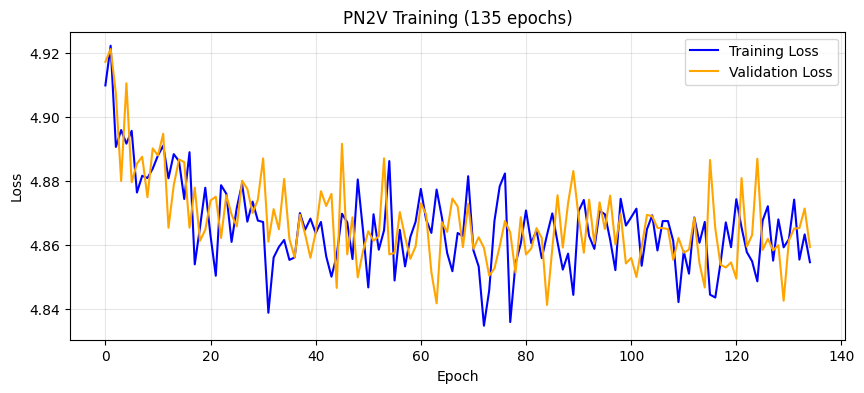


✓ PN2V training complete!
  Total epochs: 135
  Best val loss: 4.841123


In [ ]:
# NOTE: UNet, training, utils already imported in Section 5

# Print memory status before creating PN2V network
print(f"GPU Memory before PN2V:")
print(f"  Allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
print(f"  Free: {(torch.cuda.get_device_properties(0).total_memory - torch.cuda.memory_allocated()) / 1e9:.2f} GB")

# Create PN2V U-Net
pn2v_net = UNet(
    num_classes=CONFIG['pn2v_num_samples'],  # 800 (original: 800)
    in_channels=1,
    depth=CONFIG['pn2v_depth'],              # 3 (matches original)
    start_filts=CONFIG['pn2v_start_filts'],  # 64 (matches original)
    merge_mode='add'
)
pn2v_net = pn2v_net.to(device)

# Prepare training data - same structure as original
# Original: my_train_data=data[:-5].copy(), my_val_data=data[-5:].copy()
if noisy_image.ndim == 2:
    pn2v_train_data = noisy_image[np.newaxis, :, :]
    pn2v_val_data = noisy_image[np.newaxis, :, :]
else:
    pn2v_train_data = noisy_image[:-5].copy()
    pn2v_val_data = noisy_image[-5:].copy()
    np.random.shuffle(pn2v_train_data)  # Original shuffles
    np.random.shuffle(pn2v_val_data)

# Count parameters
n_params = sum(p.numel() for p in pn2v_net.parameters())

# Calculate correct number of masked pixels for this patch size
pn2v_patch_size = CONFIG['pn2v_patch_size']
pn2v_num_masked = int(pn2v_patch_size * pn2v_patch_size * CONFIG['mask_ratio'])

print(f"\nPN2V Network created:")
print(f"  Output samples: {CONFIG['pn2v_num_samples']}")
print(f"  Depth: {CONFIG['pn2v_depth']}")
print(f"  Start filters: {CONFIG['pn2v_start_filts']}")
print(f"  Parameters: {n_params:,}")
print(f"  Masked pixels per patch: {pn2v_num_masked} ({CONFIG['mask_ratio']*100}%)")
print(f"  Train data: {pn2v_train_data.shape}")
print(f"  Val data: {pn2v_val_data.shape}")

# Train PN2V - matching original structure
print("\n" + "="*60)
print("TRAINING PN2V NETWORK")
print("="*60)

pn2v_net_postfix = f"pn2v_{CONFIG['data_name']}_bootstrap"

trainHist, valHist = training.trainNetwork(
    net=pn2v_net,
    trainData=pn2v_train_data,
    valData=pn2v_val_data,
    postfix=pn2v_net_postfix,
    directory=PN2V_RESULTS_PATH,
    noiseModel=gmm_noise_model,
    device=device,
    numOfEpochs=CONFIG['pn2v_max_epochs'],           # 200 (matches original)
    stepsPerEpoch=CONFIG['pn2v_steps_per_epoch'],    # 5 (matches original)
    batchSize=CONFIG['pn2v_batch_size'],             # 1 (matches original)
    patchSize=CONFIG['pn2v_patch_size'],             # 64
    learningRate=CONFIG['pn2v_learning_rate'],       # 1e-3 (matches original)
    numMaskedPixels=pn2v_num_masked,                 # FIXED: explicitly set to match patch_size
    virtualBatchSize=20,                             # 20 (matches original)
    earlyStopPatience=CONFIG['pn2v_patience'],       # Early stopping
    maskPatchSize=CONFIG['mask_patch_size'],          # 7×7 blind spots
    useZeroReplacement=True                          # Zero replacement (matches N2V stage)
)

# Plot PN2V training curves
plt.figure(figsize=(10, 4))
plt.plot(trainHist, label='Training Loss', color='blue')
plt.plot(valHist, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'PN2V Training ({len(trainHist)} epochs)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(os.path.join(PN2V_RESULTS_PATH, f'pn2v_training_curves_{pn2v_net_postfix}.png'), dpi=150)
plt.show()

print(f"\n✓ PN2V training complete!")
print(f"  Total epochs: {len(trainHist)}")
print(f"  Best val loss: {min(valHist):.6f}")

## 🔮 Section 12: PN2V Prediction with Uncertainty

In [12]:
# NOTE: prediction module already imported in Section 5

# ============================================================
# VERIFY REQUIRED VARIABLES EXIST
# ============================================================
if 'gmm_noise_model' not in dir():
    raise RuntimeError("gmm_noise_model not found! Please run Section 10 first.")
if 'pn2v_net_postfix' not in dir():
    raise RuntimeError("pn2v_net_postfix not found! Please run Section 11 first.")

# Load best PN2V model (add weights_only=False for PyTorch 2.6+)
pn2v_net = torch.load(
    os.path.join(PN2V_RESULTS_PATH, f'best_{pn2v_net_postfix}.net'),
    map_location=device,
    weights_only=False
)
pn2v_net = pn2v_net.to(device)
pn2v_net.eval()

print(f"Loaded PN2V model from: {PN2V_RESULTS_PATH}")
print(f"  Mean: {pn2v_net.mean:.2f}")
print(f"  Std: {pn2v_net.std:.2f}")

# Prepare image for prediction
noisy_for_pred = np.squeeze(noisy_image).astype(np.float32)

print("\nRunning PN2V prediction...")
print("  This generates MMSE estimate and prior mean")

# PN2V Prediction with tiled processing for large images
# Adjust tile size based on image size
tile_size = min(256, noisy_for_pred.shape[0], noisy_for_pred.shape[1])
# Make tile_size divisible by 2^depth
divisor = 2 ** CONFIG['pn2v_depth']
tile_size = (tile_size // divisor) * divisor

pn2v_prior_mean, pn2v_mmse = prediction.tiledPredict(
    im=noisy_for_pred,
    net=pn2v_net,
    ps=tile_size,     # Tile size (must be divisible by 2^depth)
    overlap=32,       # Overlap between tiles
    noiseModel=gmm_noise_model,
    device=device
)

print(f"\n✓ PN2V Prediction complete!")
print(f"  Prior Mean shape: {pn2v_prior_mean.shape}")
print(f"  MMSE shape: {pn2v_mmse.shape}")

Loaded PN2V model from: /content/drive/MyDrive/PPN2V/results/DATASET_01/pn2v_bootstrap
  Mean: 113.66
  Std: 32.89

Running PN2V prediction...
  This generates MMSE estimate and prior mean

✓ PN2V Prediction complete!
  Prior Mean shape: (128, 128)
  MMSE shape: (128, 128)


## 📈 Section 13: Compute Uncertainty Maps

In [13]:
# Compute uncertainty from the network's sample outputs
# Run network to get all samples
noisy_norm = (noisy_for_pred - pn2v_net.mean) / pn2v_net.std

# Pad for U-Net (must be divisible by 2^depth)
H, W = noisy_norm.shape
divisor = 2 ** CONFIG['pn2v_depth']  # Use actual depth from config
pad_h = (divisor - H % divisor) % divisor
pad_w = (divisor - W % divisor) % divisor

if pad_h > 0 or pad_w > 0:
    noisy_padded = np.pad(noisy_norm, ((0, pad_h), (0, pad_w)), mode='reflect')
    print(f"Padded image from {(H, W)} to {noisy_padded.shape}")
else:
    noisy_padded = noisy_norm

# Get samples from network
input_tensor = torch.from_numpy(noisy_padded).unsqueeze(0).unsqueeze(0).float().to(device)

with torch.no_grad():
    samples = pn2v_net(input_tensor) * 10.0  # Output scaling factor

# Denormalize samples
samples_np = samples.cpu().numpy()[0]  # Shape: (num_samples, H_padded, W_padded)
samples_denorm = samples_np * pn2v_net.std + pn2v_net.mean

# Crop if padded to get back to original size
if pad_h > 0 or pad_w > 0:
    samples_denorm = samples_denorm[:, :H, :W]

print(f"Samples shape: {samples_denorm.shape}")  # Should be (num_samples, H, W)

# Compute uncertainty metrics
# 1. Standard deviation across samples (epistemic uncertainty)
std_map = np.std(samples_denorm, axis=0)

# 2. Coefficient of variation (relative uncertainty)
mean_map = np.mean(samples_denorm, axis=0)
cv_map = std_map / (np.abs(mean_map) + 1e-8)

# 3. Confidence interval width (95%)
percentile_2_5 = np.percentile(samples_denorm, 2.5, axis=0)
percentile_97_5 = np.percentile(samples_denorm, 97.5, axis=0)
ci_width = percentile_97_5 - percentile_2_5

print("✓ Uncertainty maps computed!")
print(f"  Number of samples: {samples_denorm.shape[0]}")
print(f"  Standard deviation range: [{std_map.min():.2f}, {std_map.max():.2f}]")
print(f"  95% CI width range: [{ci_width.min():.2f}, {ci_width.max():.2f}]")

Samples shape: (100, 128, 128)
✓ Uncertainty maps computed!
  Number of samples: 100
  Standard deviation range: [1.15, 18.01]
  95% CI width range: [4.81, 69.75]


## 🎨 Section 14: Visualize Uncertainty Maps

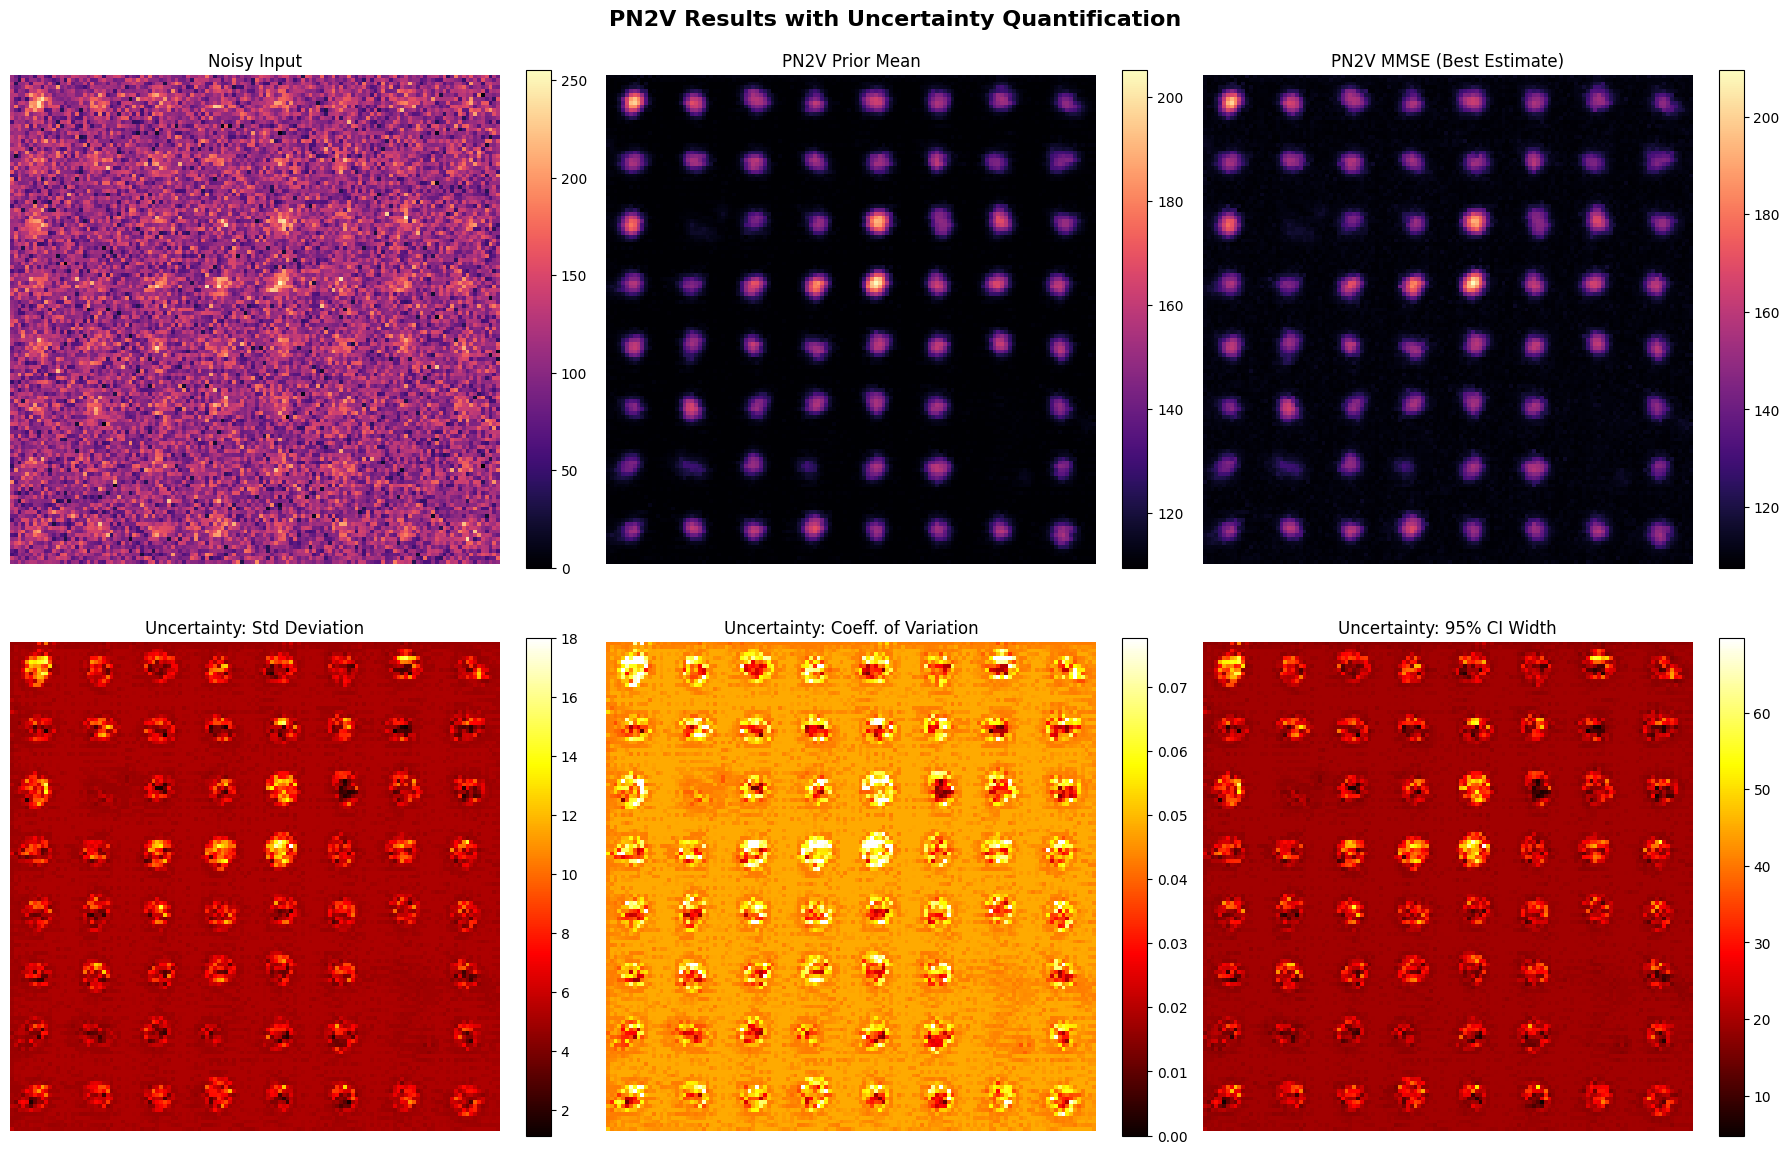

In [14]:
# Visualize uncertainty maps
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Row 1: Denoised results
im0 = axes[0, 0].imshow(noisy_image, cmap='magma')
axes[0, 0].set_title('Noisy Input', fontsize=12)
axes[0, 0].axis('off')
plt.colorbar(im0, ax=axes[0, 0], fraction=0.046)

im1 = axes[0, 1].imshow(pn2v_prior_mean, cmap='magma')
axes[0, 1].set_title('PN2V Prior Mean', fontsize=12)
axes[0, 1].axis('off')
plt.colorbar(im1, ax=axes[0, 1], fraction=0.046)

im2 = axes[0, 2].imshow(pn2v_mmse, cmap='magma')
axes[0, 2].set_title('PN2V MMSE (Best Estimate)', fontsize=12)
axes[0, 2].axis('off')
plt.colorbar(im2, ax=axes[0, 2], fraction=0.046)

# Row 2: Uncertainty maps
im3 = axes[1, 0].imshow(std_map, cmap='hot')
axes[1, 0].set_title('Uncertainty: Std Deviation', fontsize=12)
axes[1, 0].axis('off')
plt.colorbar(im3, ax=axes[1, 0], fraction=0.046)

im4 = axes[1, 1].imshow(cv_map, cmap='hot', vmin=0, vmax=np.percentile(cv_map, 99))
axes[1, 1].set_title('Uncertainty: Coeff. of Variation', fontsize=12)
axes[1, 1].axis('off')
plt.colorbar(im4, ax=axes[1, 1], fraction=0.046)

im5 = axes[1, 2].imshow(ci_width, cmap='hot')
axes[1, 2].set_title('Uncertainty: 95% CI Width', fontsize=12)
axes[1, 2].axis('off')
plt.colorbar(im5, ax=axes[1, 2], fraction=0.046)

plt.suptitle('PN2V Results with Uncertainty Quantification', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(PN2V_RESULTS_PATH, f'pn2v_uncertainty_{CONFIG["data_name"]}.png'), dpi=150, bbox_inches='tight')
plt.show()

## ⚖️ Section 15: Compare N2V vs PN2V

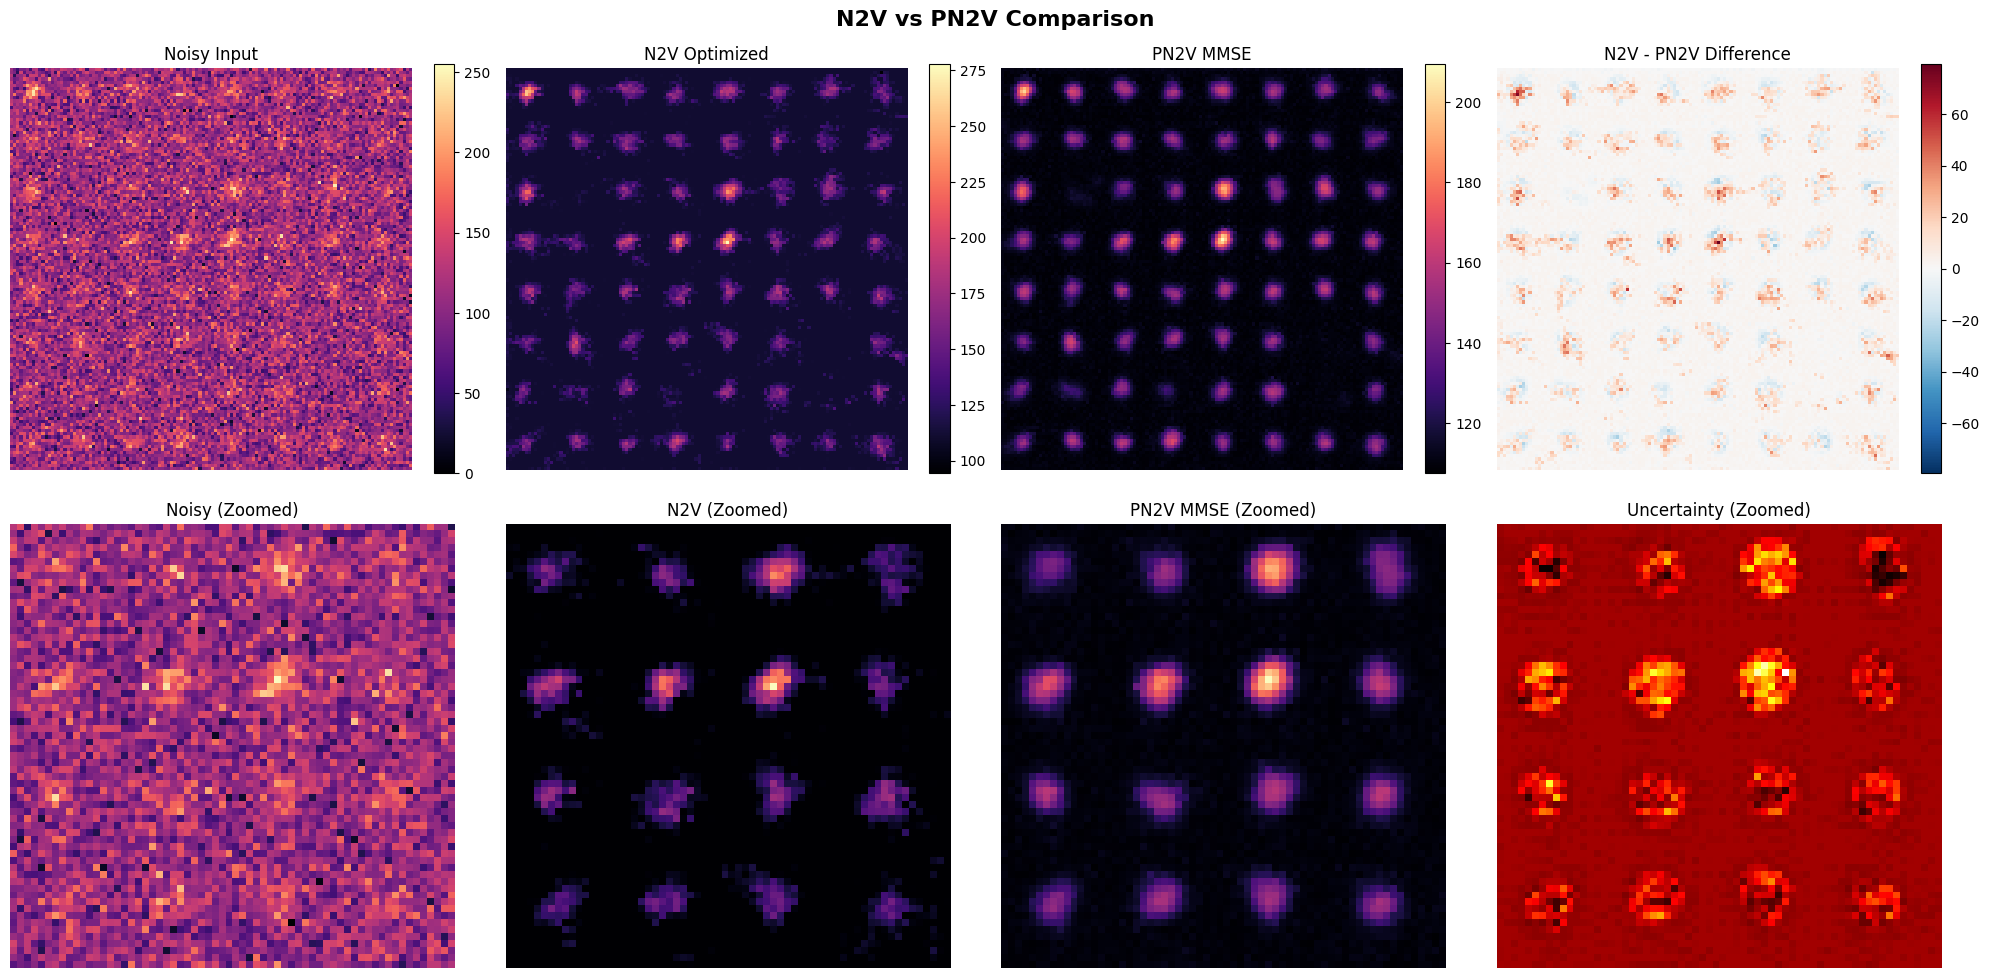


COMPARISON STATISTICS

N2V Optimized:
  Mean: 116.34
  Std: 13.90

PN2V MMSE:
  Mean: 114.06
  Std: 10.43

Method Difference (N2V - PN2V):
  Mean absolute diff: 3.7581
  Max absolute diff: 79.3295


In [15]:
# Side-by-side comparison of N2V vs PN2V
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# Row 1: Full images
im0 = axes[0, 0].imshow(noisy_image, cmap='magma')
axes[0, 0].set_title('Noisy Input', fontsize=12)
axes[0, 0].axis('off')
plt.colorbar(im0, ax=axes[0, 0], fraction=0.046)

im1 = axes[0, 1].imshow(n2v_denoised, cmap='magma')
axes[0, 1].set_title('N2V Optimized', fontsize=12)
axes[0, 1].axis('off')
plt.colorbar(im1, ax=axes[0, 1], fraction=0.046)

im2 = axes[0, 2].imshow(pn2v_mmse, cmap='magma')
axes[0, 2].set_title('PN2V MMSE', fontsize=12)
axes[0, 2].axis('off')
plt.colorbar(im2, ax=axes[0, 2], fraction=0.046)

# Difference between methods
method_diff = n2v_denoised - pn2v_mmse
vmax_diff = np.abs(method_diff).max()
im3 = axes[0, 3].imshow(method_diff, cmap='RdBu_r', vmin=-vmax_diff, vmax=vmax_diff)
axes[0, 3].set_title('N2V - PN2V Difference', fontsize=12)
axes[0, 3].axis('off')
plt.colorbar(im3, ax=axes[0, 3], fraction=0.046)

# Row 2: Zoomed comparison
h, w = noisy_image.shape
crop_size = min(256, h//2, w//2)
cy, cx = h//2, w//2
y1, y2 = cy - crop_size//2, cy + crop_size//2
x1, x2 = cx - crop_size//2, cx + crop_size//2

axes[1, 0].imshow(noisy_image[y1:y2, x1:x2], cmap='magma')
axes[1, 0].set_title('Noisy (Zoomed)', fontsize=12)
axes[1, 0].axis('off')

axes[1, 1].imshow(n2v_denoised[y1:y2, x1:x2], cmap='magma')
axes[1, 1].set_title('N2V (Zoomed)', fontsize=12)
axes[1, 1].axis('off')

axes[1, 2].imshow(pn2v_mmse[y1:y2, x1:x2], cmap='magma')
axes[1, 2].set_title('PN2V MMSE (Zoomed)', fontsize=12)
axes[1, 2].axis('off')

axes[1, 3].imshow(std_map[y1:y2, x1:x2], cmap='hot')
axes[1, 3].set_title('Uncertainty (Zoomed)', fontsize=12)
axes[1, 3].axis('off')

plt.suptitle('N2V vs PN2V Comparison', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(COMPARISON_PATH, f'n2v_vs_pn2v_{CONFIG["data_name"]}.png'), dpi=150, bbox_inches='tight')
plt.show()

# Print comparison statistics
print("\n" + "="*60)
print("COMPARISON STATISTICS")
print("="*60)
print(f"\nN2V Optimized:")
print(f"  Mean: {n2v_denoised.mean():.2f}")
print(f"  Std: {n2v_denoised.std():.2f}")
print(f"\nPN2V MMSE:")
print(f"  Mean: {pn2v_mmse.mean():.2f}")
print(f"  Std: {pn2v_mmse.std():.2f}")
print(f"\nMethod Difference (N2V - PN2V):")
print(f"  Mean absolute diff: {np.abs(method_diff).mean():.4f}")
print(f"  Max absolute diff: {np.abs(method_diff).max():.4f}")
print("="*60)

## 💾 Section 16: Save All Results

In [16]:
# Save PN2V results
data_name = CONFIG['data_name']

# PN2V denoised images
tifffile.imwrite(os.path.join(PN2V_RESULTS_PATH, f'pn2v_prior_mean_{data_name}.tif'),
                 pn2v_prior_mean.astype(np.float32))
tifffile.imwrite(os.path.join(PN2V_RESULTS_PATH, f'pn2v_mmse_{data_name}.tif'),
                 pn2v_mmse.astype(np.float32))

# Uncertainty maps
tifffile.imwrite(os.path.join(PN2V_RESULTS_PATH, f'uncertainty_std_{data_name}.tif'),
                 std_map.astype(np.float32))
tifffile.imwrite(os.path.join(PN2V_RESULTS_PATH, f'uncertainty_cv_{data_name}.tif'),
                 cv_map.astype(np.float32))
tifffile.imwrite(os.path.join(PN2V_RESULTS_PATH, f'uncertainty_ci95_{data_name}.tif'),
                 ci_width.astype(np.float32))

# Comparison results
tifffile.imwrite(os.path.join(COMPARISON_PATH, f'n2v_denoised_{data_name}.tif'),
                 n2v_denoised.astype(np.float32))
tifffile.imwrite(os.path.join(COMPARISON_PATH, f'pn2v_mmse_{data_name}.tif'),
                 pn2v_mmse.astype(np.float32))
tifffile.imwrite(os.path.join(COMPARISON_PATH, f'method_difference_{data_name}.tif'),
                 method_diff.astype(np.float32))

print("="*60)
print("✅ ALL RESULTS SAVED")
print("="*60)

print(f"\n📁 N2V Results: {N2V_RESULTS_PATH}")
for f in os.listdir(N2V_RESULTS_PATH):
    size_kb = os.path.getsize(os.path.join(N2V_RESULTS_PATH, f)) / 1024
    print(f"   📄 {f} ({size_kb:.1f} KB)")

print(f"\n📁 PN2V Results: {PN2V_RESULTS_PATH}")
for f in os.listdir(PN2V_RESULTS_PATH):
    size_kb = os.path.getsize(os.path.join(PN2V_RESULTS_PATH, f)) / 1024
    print(f"   📄 {f} ({size_kb:.1f} KB)")

print(f"\n📁 Comparison: {COMPARISON_PATH}")
for f in os.listdir(COMPARISON_PATH):
    size_kb = os.path.getsize(os.path.join(COMPARISON_PATH, f)) / 1024
    print(f"   📄 {f} ({size_kb:.1f} KB)")

print("\n" + "="*60)

✅ ALL RESULTS SAVED

📁 N2V Results: /content/drive/MyDrive/PPN2V/results/DATASET_01/n2v_optimized
   📄 best_n2v_DATASET_01_d3_w4.pth (44.5 KB)
   📄 history_n2v_DATASET_01_d3_w4.npy (1.7 KB)
   📄 last_n2v_DATASET_01_d3_w4.pth (44.5 KB)
   📄 training_curves_n2v_DATASET_01_d3_w4.png (76.2 KB)
   📄 n2v_comparison_n2v_DATASET_01_d3_w4.png (269.6 KB)
   📄 n2v_denoised_DATASET_01.tif (64.3 KB)
   📄 n2v_noise_removed_DATASET_01.tif (64.3 KB)
   📄 historyn2v_DATASET_01_d3_f32.npy (0.2 KB)
   📄 best_n2v_DATASET_01_d3_f32.net (1656.8 KB)
   📄 last_n2v_DATASET_01_d3_f32.net (1656.8 KB)
   📄 seed_42 (4.0 KB)
   📄 seed_43 (4.0 KB)
   📄 seed_44 (4.0 KB)
   📄 seed_45 (4.0 KB)
   📄 seed_46 (4.0 KB)
   📄 experiment_summary.npy (29.3 KB)
   📄 n2v_comparison.png (233.4 KB)
   📄 epoch_averages.csv (11.9 KB)
   📄 avg_loss_vs_epochs.png (62.5 KB)

📁 PN2V Results: /content/drive/MyDrive/PPN2V/results/DATASET_01/pn2v_bootstrap
   📄 last_pn2v_DATASET_01_bootstrap.net (44.6 KB)
   📄 best_pn2v_DATASET_01_bootstra

## 📤 Section 17: Commit to GitHub (Optional)

---

## 🎉 Pipeline Complete!

You have successfully run the complete N2V → PN2V pipeline:

### Stage 1: N2V Optimized ✅
- Fast denoising with optimized blind-spot configuration
- Results in: `Google Drive/MyDrive/PPN2V/results/n2v_optimized/`

### Stage 2: PN2V Bootstrap ✅
- Used N2V output as signal estimate for noise model
- Trained GMM noise model + PN2V network
- Results in: `Google Drive/MyDrive/PPN2V/results/pn2v_bootstrap/`

### Comparison & Uncertainty ✅
- Side-by-side N2V vs PN2V comparison
- Uncertainty maps (Std Dev, Coeff. of Variation, 95% CI)
- Results in: `Google Drive/MyDrive/PPN2V/results/comparison/`

---

### Output Files Summary:

| Directory | File | Description |
|-----------|------|-------------|
| `n2v_optimized/` | `n2v_denoised_*.tif` | N2V denoised image |
| `n2v_optimized/` | `best_*.pth` | Best N2V model |
| `pn2v_bootstrap/` | `pn2v_mmse_*.tif` | PN2V MMSE estimate |
| `pn2v_bootstrap/` | `uncertainty_std_*.tif` | Standard deviation map |
| `pn2v_bootstrap/` | `uncertainty_cv_*.tif` | Coefficient of variation map |
| `pn2v_bootstrap/` | `uncertainty_ci95_*.tif` | 95% confidence interval width |
| `comparison/` | `n2v_vs_pn2v_*.png` | Visual comparison |
| `comparison/` | `method_difference_*.tif` | Difference between methods |